In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pypsa
import pandas as pd
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D
import seaborn as sns

In [15]:
%matplotlib inline
plt.style.use("bmh")

## Stats

In [16]:
def check_curtailment(n):
    possible = (n.generators_t.p_max_pu * n.generators.p_nom_opt).filter(regex="(ror|solar|wind)", axis=1).sum().sum()
    generated = n.generators_t.p.filter(regex="(ror|solar|wind)", axis=1).sum().sum()
    return (1 - generated / possible) * 100 # %

In [17]:
def check_energy_balance(n):
    gen = n.generators_t.p.multiply(n.snapshot_weightings, axis=0).sum().sum()
    sto = n.storage_units_t.p.multiply(n.snapshot_weightings, axis=0).sum().sum()
    load = n.loads_t.p_set.multiply(n.snapshot_weightings, axis=0).sum().sum()
    if "loss" in n.lines_t.keys():
        line_loss = n.lines_t.loss.multiply(n.snapshot_weightings, axis=0).sum().sum()
    else:
        line_loss = 0
    link_loss = (n.links_t.p0 + n.links_t.p1).multiply(n.snapshot_weightings, axis=0).sum().sum()
    loss = link_loss + line_loss
    loss_share = loss / (gen+sto) * 100 # %
    balance = (gen + sto - loss - load) / 1e6 # TWh
    return balance, loss_share, link_loss / 1e6, line_loss/ 1e6

In [18]:
def check_energy_transmitted(n, branch="lines"):
    branches_t = getattr(n, branch+"_t")
    branches = getattr(n, branch)
    return branches_t.p0.abs().multiply(n.snapshot_weightings, axis=0).multiply(branches.length).sum().sum() / 1e6 # TWhkm

In [19]:
def check_energy_generated(n):
    n.generators["energy"] = n.generators_t.p.multiply(n.snapshot_weightings, axis=0).sum()
    generated = n.generators.groupby("carrier").energy.sum() / 1e6 # TWh
    generated["inflow"] = n.storage_units_t.inflow.multiply(n.snapshot_weightings, axis=0).sum().sum() / 1e6 # TWh
    return generated

In [20]:
def check_costs(n):
    
    abs_c = aggregate_costs(n).sum() # bn EUR/a
    rel_c = abs_c / n.loads_t.p_set.multiply(n.snapshot_weightings, axis=0).sum().sum() * 1e9 # EUR/MWh
    
    return abs_c, rel_c

In [21]:
def check_capacities(n):
    
    return pd.concat([
        n.generators.groupby("carrier").p_nom_opt.sum() / 1e3, # GW
        n.storage_units.groupby("carrier").p_nom_opt.sum() / 1e3, # GW
        pd.Series({"links": n.links.eval("length * (p_nom_opt - p_nom) / 1e6 / 2").sum()}), # TWkm  # links are split and p_nom_opt thus counted double
        pd.Series({"lines": n.lines.eval("length * (s_nom_opt - s_nom) / 1e6").sum()}) # TWkm
    ])

In [22]:
def check_flow_errors(n, n_pf):
    
    pf = n_pf.lines_t.p0.stack()

    lopf = n.lines_t.p0.stack()

    mse = pf.sub(lopf).pow(2).mean()
    rmse = mse ** 0.5
    mape = pf.sub(lopf).div(pf).abs().mean()
    mae = pf.sub(lopf).abs().mean()
    corr = pf.corr(lopf)
    r2 = corr ** 2
    return (mse, rmse, mae, mape, corr, r2)

In [23]:
def check_slack(n_pf, logs):
    converged = logs.converged.all(axis=1)

    valley_q = n_pf.generators_t.q.loc[converged].sum(axis=1).min() / 1e3 # GW
    peak_q = n_pf.generators_t.q.loc[converged].sum(axis=1).max() / 1e3 # GW
    tvarh = n_pf.generators_t.q.loc[converged].multiply(n.snapshot_weightings, axis=0).sum().sum() / 1e6 # Tvarh

    slack = (n_pf.generators_t.p - n_pf.generators_t.p_set).loc[converged]
    twh = slack.multiply(n_pf.snapshot_weightings, axis=0).sum().sum() / 1e6 # TWh
    peak_p = slack.sum(axis=1).max() / 1e3 # GW
    valley_p = slack.sum(axis=1).min() / 1e3 # GW
    
    return (twh, peak_p, valley_p, tvarh, peak_q, valley_q)

## Multiuse Functions

In [24]:
def plot_hist_helper(ax, x, y, xlim, ylim, style='hexbin', vmin=0, vmax=400):
    
    if style == "scatter":
        ax.scatter(x, y, alpha=0.2, marker=".")
    elif style == "hexbin":
        scope = xlim + ylim
        plt.hexbin(x, y, gridsize=100, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, extent=xlim + ylim)
    elif style == "hist2d":
        scope = np.array([xlim, ylim])
        plt.hist2d(x, y, bins=100, cmap=plt.cm.viridis, vmin=vmin, vmax=vmax, linewidths=0, range=scope)

In [25]:
def reference(ax, low, high, res=100, lw=1, c="k", f=lambda x: x):
    x = np.linspace(low,high,res)
    ax.plot(x,f(x),c='k',linewidth=lw);

In [26]:
def line_loading(n, apparent=True, relative=True):
    p = np.maximum(n.lines_t.p0.abs(), n.lines_t.p1.abs())
    
    if apparent:
        q = np.maximum(n.lines_t.q0.abs(), n.lines_t.q1.abs())
    else:
        q = 0
        
    s = np.sqrt(p**2 + q**2)
    
    if relative:
        return s / n.lines.s_nom_opt
    else:
        return s

## Single LOPF: Maps

In [27]:
def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()
    def axes2pt():
        return np.diff(ax.transData.transform([(0,0), (1,1)]), axis=0)[0] * (300./fig.dpi)

    ellipses = []
    if not dont_resize_actively:
        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses: e.width, e.height = 2. * radius * dist
        fig.canvas.mpl_connect('resize_event', update_width_height)
        ax.callbacks.connect('xlim_changed', update_width_height)
        ax.callbacks.connect('ylim_changed', update_width_height)

    def legend_circle_handler(legend, orig_handle, xdescent, ydescent,
                              width, height, fontsize):
        w, h = 2. * orig_handle.get_radius() * axes2pt()
        e = Ellipse(xy=(0.5*width-0.5*xdescent, 0.5*height-0.5*ydescent), width=w, height=w)
        ellipses.append((e, orig_handle.get_radius()))
        return e
    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}

In [28]:
def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0,0), radius=(s/scale)**0.5, **kw) for s in sizes]

In [29]:
def add_legend(ax, bus_factor, branch_factor):
    
    handles = []
    labels = []
    for s in (2,5,10):
        handles.append(plt.Line2D([0],[0],color='rosybrown',
                                  linewidth=s*1e3/branch_factor))
        labels.append(f"{s} GW")
    l1 = ax.legend(handles, labels,
                   loc="upper left", bbox_to_anchor=(0,0),
                   frameon=False,
                   labelspacing=0.8, handletextpad=1.5,
                   title='HVAC Line Capacity')
    ax.add_artist(l1)
    
    handles = []
    labels = []
    for s in (2,5,10):
        handles.append(plt.Line2D([0],[0],color='darkseagreen',
                                  linewidth=s*1e3/branch_factor))
        labels.append(f"{s} GW")
    l2 = ax.legend(handles, labels,
                   loc="upper left", bbox_to_anchor=(0.2, -0.),
                   frameon=False,
                   labelspacing=0.8, handletextpad=1.5,
                   title='HVDC Link Capacity')
    ax.add_artist(l2)
    
    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    for name, carrier in n.carriers.iterrows():
        handles.append(plt.Line2D([0], [0], color=carrier.color, marker='o', markersize=8, linewidth=0))
        labels.append(carrier.nice_name)
    l3 = ax.legend(handles, labels, loc="upper center",  bbox_to_anchor=(0.58, -0.), # bbox_to_anchor=(0.72, -0.05),
                   handletextpad=0., columnspacing=0.5, ncol=2, title='Technology', frameon=False)
    ax.add_artist(l3)
                      
    circles = [5000, 1000, 100]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{int(s/1e2)} GW" for s in circles]
    l4 = ax.legend(handles, labels,
                   loc="upper left", bbox_to_anchor=(0.82, 0.),
                   frameon=False, labelspacing=2.5,
                   title='Generation',
                   handler_map=make_handler_map_to_scale_circles_as_in(ax, True))
    ax.add_artist(l4)

In [30]:
def plot_network(n, fn=None):
    
    bus_factor = 5.5e4
    branch_factor = 2e3

    fields = ["bus", "carrier", "p_nom_opt"]
    pie_components = pd.concat([n.generators.loc[n.generators.carrier!="load",fields], n.storage_units[fields]])
    bus_sizes = pie_components.groupby(["bus","carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df>thres, other=0.)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = clip(n.lines.s_nom_opt) / branch_factor

    fig, ax = plt.subplots(figsize=(11,11), subplot_kw={"projection":ccrs.PlateCarree()})

    n.plot(ax=ax, bus_sizes=bus_sizes, color_geomap=True, bus_alpha=0.7, line_widths=line_widths_opt, line_colors='#dddddd');

    n.plot(ax=ax, geomap=False, bus_sizes=0, line_widths=line_widths, link_widths=link_widths);

    add_legend(ax, bus_factor, branch_factor)

    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Single PF Plots

In [31]:
def plot_network_losses(n, fn=None):
    
    lc = n.lines_t.loss.mean()
    lw = line_loading(n, apparent=False, relative=False).mean() / 700

    fig, ax = plt.subplots(figsize=(7,7), subplot_kw={"projection":ccrs.PlateCarree()})
    
    n.plot(ax=ax, color_geomap=True, line_widths=lw, line_colors=lc, bus_sizes=5e-3, bus_colors="darkgray", bus_alpha=0.8, link_widths=0)

    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")

In [32]:
def plot_v_ang_diff(n_pf, fn=None):

    v_ang_1 = n_pf.buses_t.v_ang.loc[:,n_pf.lines.bus1]
    v_ang_1.columns = n_pf.lines.index

    v_ang_0 = n_pf.buses_t.v_ang.loc[:,n_pf.lines.bus0]
    v_ang_0.columns = n_pf.lines.index

    v_ang_diff = (v_ang_1 - v_ang_0).applymap(lambda x: x*180/np.pi)
    
    fig, ax = plt.subplots(figsize=(5,3))

    v_ang_diff.stack().plot.hist(bins=np.arange(-90,90,5), density=True)
    
    plt.xticks(np.arange(-90,90,10), rotation=90)
    
    plt.xlabel("Voltage Angle Difference [Degrees]")
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Single LOPF: Plots

In [151]:
def plot_flow_vs_loss(n, norm="max", style="hist2d", title="", fn=None):

    fig, ax = plt.subplots(figsize=(6,5))

    loading = (n.lines_t.p0 / n.lines[f"s_nom_{norm}"] / n.lines.s_max_pu).stack()
    max_loss = n.lines.r_pu_eff * (n.lines.s_max_pu * n.lines[f"s_nom_{norm}"]) ** 2
    relative_loss = (n.lines_t.loss / max_loss).stack()

    xlim = [-1,1]
    ylim = [0,1.1]

    plot_hist_helper(ax, loading, relative_loss, xlim, ylim, vmax=100, style=style)

    reference(ax, *xlim, f=lambda x: x ** 2)
    
    if style in ["hexbin", "hist2d"]:
        cb = plt.colorbar(ax=ax, shrink=0.95)
        cb.set_label('Count')

    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    plt.ylabel("Rel. Losses (LOPF)")
    plt.xlabel("Rel. Line Flows (LOPF)")
    
    plt.title(title)
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

In [34]:
def plot_negative_marginal_prices(n, fn=None, max_mp=-0.5):

    mp = n.buses_t.marginal_price.stack()

    neg_mp = pd.Series(mp.loc[mp<max_mp].sort_values().values)
    
    if neg_mp.empty: return

    fig, ax = plt.subplots(figsize=(5,4))
    neg_mp.plot(ax=ax)

    plt.ylabel("EUR/MWh")
    plt.xlabel("Count")
    plt.title(f"Frequency: {len(neg_mp) / len(mp) * 100:f} %")

    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Single (LOPF, PF): Plots

In [35]:
def plot_loss_comparison(n, n_pf, style="hist2d", title="", fn=None, norm="max"):

    fig, ax = plt.subplots(figsize=(6,5))

    max_loss = n.lines.r_pu_eff * (n.lines.s_max_pu * n.lines[f"s_nom_{norm}"]) ** 2

    pf_loss = ((n_pf.lines_t.p0 + n_pf.lines_t.p1) / max_loss).stack()
    lopf_loss = (n.lines_t.loss / max_loss).stack()
    
    xlim = [0,1]
    ylim = [0,1.2]

    plot_hist_helper(ax, lopf_loss, pf_loss, xlim, ylim, style=style, vmax=100)

    reference(ax, *xlim, f=lambda x: x)
    
    if style in ["hexbin", "hist2d"]:
        cb = plt.colorbar(ax=ax, shrink=0.95)
        cb.set_label('Count')
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    plt.xlabel("Rel. Losses (LOPF)")
    plt.ylabel("Rel. Losses (PF)")
    
    plt.title(title)
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

In [181]:
def plot_flow_comparison(n, n_pf, style="hist2d", title="", fn=None):
    
    pf = n_pf.lines_t.loading.stack()
    lopf = n.lines_t.loading.stack()

    fig, ax = plt.subplots(figsize=(6,5))

    xlim = [-1.1,1.1]
    ylim = [-.8,.8]

    plot_hist_helper(ax, pf, lopf, xlim, ylim, style=style, vmax=600)

    if style in ["hexbin", "hist2d"]:
        cb = plt.colorbar(ax=ax, shrink=0.75)
        cb.set_label('Count')

    reference(ax, -1,1)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    ax.set_yticks(np.arange(ylim[0], ylim[1]+0.1, 0.2))
    ax.set_xticks(np.arange(xlim[0]+0.1, xlim[1]+0.1, 0.2))
    plt.xticks(rotation=90)
    
    ax.set_aspect(1)
    
    plt.xlabel("Rel. Line Flows (PF)")
    plt.ylabel("Rel. Line Flows (LOPF)")
    
    plt.title(title)
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

In [37]:
def plot_duration_curve(n, n_pf, apparent=True, fn=None):
    fig, ax = plt.subplots(figsize=(5,4))
    
    def duration_curve(nc, s=True, l=""):
        series = pd.Series(line_loading(nc, apparent=s).stack().sort_values(ascending=False).values)
        series.index = [i/len(series)*100 for i in series.index]
        series.plot(ax=ax, label=l)
        
    duration_curve(n, s=False, l="LOPF (Approx. power flow)")
    duration_curve(n_pf, s=apparent, l="PF (AC power flow)")
    
    plt.ylim([-0.1,1.4])
    plt.legend(loc="upper right")
    plt.ylabel("Relative Line Loading [-]")
    plt.xlabel("Share of Snapshots [%]")
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Multiple LOPF: Bar Charts

In [38]:
def assign_carriers(n):
    
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    
    if "carrier" not in n.lines:
        n.lines["carrier"] = "AC"

    if n.links.empty: n.links["carrier"] = pd.Series(dtype=str)
        
    config = {
        "AC": {"color": "rosybrown", 'nice_name': "HVAC Line"},
        "DC": {"color": "darkseagreen", 'nice_name': "HVDC Link"}
    }
        
    for c in ["AC", "DC"]:
        if c in n.carriers.index: continue
        n.carriers = n.carriers.append(pd.Series(config[c], name=c))

In [39]:
def aggregate_costs(n, existing_only=False, by_carrier=True):

    components = dict(Link=("p_nom", "p0"),
                      Generator=("p_nom", "p"),
                      StorageUnit=("p_nom", "p"),
                      Store=("e_nom", "p"),
                      Line=("s_nom", None))

    costs = {}
    for c in n.iterate_components(components.keys()):
        p_nom, p_attr = components[c.name]
        if c.df.empty: continue
        if not existing_only: p_nom += "_opt"
        costs[(c.list_name, 'capital')] = (c.df[p_nom] * c.df.capital_cost).groupby(c.df.carrier).sum()
        if p_attr is not None:
            p = c.pnl[p_attr].multiply(n.snapshot_weightings, axis=0).sum()
            if c.name == 'StorageUnit':
                p = p.loc[p > 0]
            costs[(c.list_name, 'marginal')] = (p*c.df.marginal_cost).groupby(c.df.carrier).sum()
    costs = pd.concat(costs) / 1e9 # bn EUR/a
    
    if by_carrier:
        costs = costs.groupby(level=2).sum()

    return costs

In [40]:
def plot_cost_bar(networks, model_names, fn=None):
    
    for n in networks.values():
        assign_carriers(n)

    costs = pd.concat({k: aggregate_costs(v) for k,v in networks.items()}, axis=1).T

    if "load" in costs.columns:
        costs.drop(columns=["load"], inplace=True)

    colors = n.carriers.color.reindex(index=costs.columns).values

    costs.rename(columns=n.carriers.nice_name, index=model_names, inplace=True)
    costs.columns.name = "Technology"

    fig, ax = plt.subplots(figsize=(8,4))

    costs.plot.bar(ax=ax, stacked=True, color=colors)

    plt.legend(ncol=1, bbox_to_anchor=(1,1.02))

    plt.xticks(rotation=0)
    plt.ylabel("Total System Costs [bn Euro / a]")
    
    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")

In [41]:
def optimised_capacities(n, c, regex="()"):
    attr = "s" if c == "Line" else "p"
    return n.df(c)[f"{attr}_nom_opt"].filter(regex=regex)

In [42]:
def plot_capacity_correlation(networks, c, regex="", fn=None):
    
    regex = "(" + regex + ")"
    
    df = pd.DataFrame({fm: optimised_capacities(n, c, regex) for fm, n in networks.items()})
    df.rename(columns=model_names, inplace=True)

    corr = df.corr()

    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(df.corr(), vmin=0.5, mask=mask, cmap='viridis', square=True, annot=True, fmt=".2", ax=ax, cbar=False)
    
    plt.title(f"{c} {regex[1:-1]}")
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Feasible Space

In [43]:
def plot_feasible_space(line, fn=None):
    
    print(line[["s_nom", 's_max_pu', 'r_pu_eff', "s_nom_max"]])

    fig, ax = plt.subplots(figsize=(5,4.5))

    x = np.linspace(-line.s_nom,line.s_nom,100)

    plt.plot(x, line.r_pu_eff * x**2, c='k', label=r"$\psi=rp^2$")

    plt.axhline(0, c='firebrick', label=r"$\psi\geq 0$")

    max_loss = line.r_pu_eff*(line.s_max_pu*line.s_nom)**2
    ax.axhline(max_loss, c='darkseagreen', label=r"$\psi\leq r(\bar{p}P)^2$")

    flow_upper = -x+line.s_max_pu*line.s_nom
    flow_lower = x+line.s_max_pu*line.s_nom
    plt.plot(x, flow_upper, c='navy', linestyle="--", label=r"$\psi+|p| \leq \bar{p}P$")
    plt.plot(x, flow_lower, c='navy', linestyle="--")

    tangents = []
    for k in [1,2]:
        p_k = k / 2 * line.s_max_pu * line.s_nom
        loss_k = line.r_pu_eff * p_k ** 2
        slope_k = 2 * line.r_pu_eff * p_k
        offset_k = loss_k - slope_k * p_k
        for sign in [-1,1]:
            tangent = sign*slope_k*x+offset_k
            tangents.append(tangent)
            plt.plot(x, tangent, c='k', linestyle=':')


    min_loss = [min(max_loss,max(0,max(i))) for i in zip(*tangents)]
    plt.fill_between(x, max_loss, min_loss, alpha=0.2, color='firebrick', label="Feasible Space")

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Line2D([0], [0], color='k', linestyle=':', label='Tangents'))

    plt.xlabel("Line Flow [MW]")
    plt.ylabel("Line Losses [MW]")
    plt.ylim([-5,max_loss/line.s_max_pu**2*0.8])
    plt.legend(handles=handles)

    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Multiple LOPF: Memory and Time

In [44]:
def load_memory(fn):
    memlog = pd.read_csv(fn, sep=' ', index_col=1, usecols=[1,2], header=None).squeeze()
    memlog.index = [t - memlog.index[0] for t in memlog.index]
    return memlog

In [45]:
def process_logs(logs):
    attrs = ["time", "peak_mem"]
    df = pd.DataFrame(columns=logs.keys(), index=attrs)
    for fm, mem in logs.items():
        df.at["time", fm] = mem.index[-1] / 3600 # h
        df.at["peak_mem", fm] = mem.max() / 1e3 # GB
    return df

In [125]:
def plot_performance(logs, attr, model_names=None, colors='forestgreen', fn=None):
    
    df = process_logs(logs)
    
    if model_names is not None:
        df.rename(columns=model_names, inplace=True)
        
    fig, ax = plt.subplots(figsize=(4.5,2.5))
        
    df.T[attr].plot.bar(ax=ax, color=colors)
    
    if attr == "peak_mem":
        plt.ylabel("Peak Memory [GB]")
    else:
        plt.ylabel("Solving Time [h]")
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Power Flow Convergence

In [47]:
# careful, this is a bit hard-coded!
def convergence_share(log, fm):
    conv = log.converged.astype(int)
    conv.columns = ["Continental Europe", "Nordic", "Baltic", "Mallorca", "Ireland", "Great Britain", "Sicily"]
    conv = conv.drop(columns=["Mallorca", "Sicily"])
    conv_share = (1 - conv.sum() / len(conv)) * 100  # %
    conv_share.name = fm
    return conv_share

In [48]:
def plot_nonconverged(conv_share, fn=None):

    fig, ax = plt.subplots(figsize=(6,2.5))
    conv_share.rename(columns=model_names, inplace=True)
    conv_share.T.plot.bar(ax=ax)
    
    plt.legend(title="Synchronous Zone")
    plt.ylabel("Snapshots not\nconverged [%]")
    
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')

## Application

In [129]:
flow_models = ["transport", "lossytransport", "lossless-0", "lossless-3", "lossy-3-0", "lossy-5-0", "lossy-3-3", "lossy-5-3"]
#flow_models = ["transport", "lossytransport"]

In [130]:
logs = {fm: load_memory(f"logs/elec_s_37_lcopt_6H_M{fm}_memory.log") for fm in flow_models}

In [131]:
pflogs = {fm: pd.read_csv(f"results/pf/log_elec_s_37_ec_lcopt_6H_M{fm}_Sdistributed.csv", index_col=0, header=[0,1]) for fm in flow_models}

In [158]:
networks = {fm: pypsa.Network(f"results/networks/elec_s_37_ec_lcopt_6H_M{fm}.nc") for fm in flow_models}

Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_6H_Mtransport.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_6H_Mlossytransport.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_6H_Mlossless-0.nc has buses, carriers, generators, lines, links, loads, storage_units
Importi

In [133]:
networks_pf = {fm: pypsa.Network(f"results/pf/elec_s_37_ec_lcopt_6H_M{fm}_Sdistributed.nc") for fm in flow_models}

Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_6H_Mtransport_Sdistributed.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_6H_Mlossytransport_Sdistributed.nc has buses, carriers, generators, lines, links, loads, storage_units
Importing PyPSA from older version of PyPSA than current version 0.17.0.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network elec_s_37_ec_lcopt_6H_Mlossless-0_Sdistributed.nc has buses, carriers, generators, lin

In [182]:
for n in networks.values():
    assign_carriers(n)
    if "lossy" in n.flow_model:
        n.lines_t["p0l"] = n.lines_t.p0 + n.lines_t.loss.where(n.lines_t.p0>0).fillna(0.)
        n.lines_t["p1l"] = n.lines_t.p1 + n.lines_t.loss.where(n.lines_t.p1>0).fillna(0.)
        n.lines_t["loading"] = n.lines_t.p0 + n.lines_t.loss.where(n.lines_t.p0>0).fillna(0.) - n.lines_t.loss.where(n.lines_t.p0<0).fillna(0.)
    else:
        n.lines_t["loading"] = n.lines_t.p0

for npf in networks_pf.values():
    npf.lines_t["loading"] = npf.lines_t.p0.where(npf.lines_t.p0>0).fillna(0.) - npf.lines_t.p1.where(npf.lines_t.p1>0).fillna(0.)

In [183]:
model_names = {
    "transport": "Transport",
    "lossytransport": "Lossy\nTransport",
    "lossless-0": "Lossless",
    "lossy-3-0": "Lossy (3T)",
    "lossy-5-0": "Lossy (5T)",
    "lossless-3": "Iterative\nLossless",
    "lossy-3-3": "Iterative\nLossy (3T)",
    "lossy-5-3": "Iterative\nLossy (5T)"
}

In [184]:
d = "summary/"

In [185]:
csvargs = {"float_format": "%.3f"}

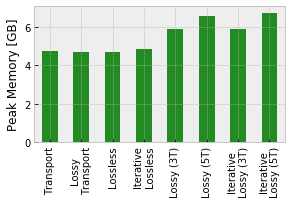

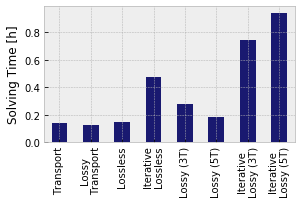

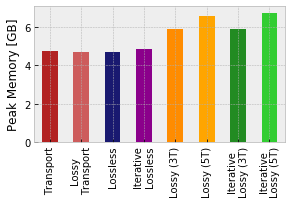

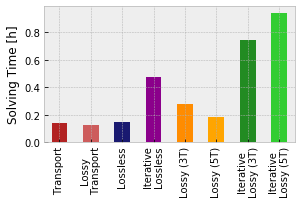

In [186]:
plot_performance(logs, 'peak_mem', model_names, colors="forestgreen", fn=f"{d}memory.pdf")
plot_performance(logs, 'time', model_names, colors="midnightblue", fn=f"{d}time.pdf")

c = ['firebrick', 'indianred', 'midnightblue', 'darkmagenta', "darkorange", "orange", "forestgreen", "limegreen"]
plot_performance(logs, 'peak_mem', model_names, colors=c, fn=f"{d}memory-c.pdf")
plot_performance(logs, 'time', model_names, colors=c, fn=f"{d}time-c.pdf")

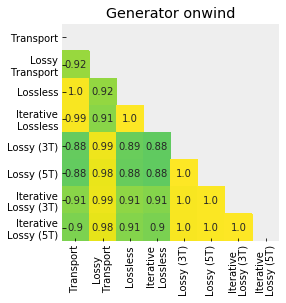

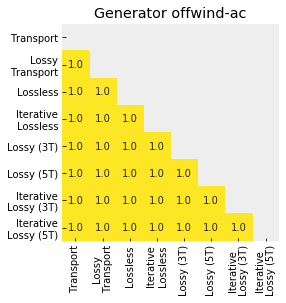

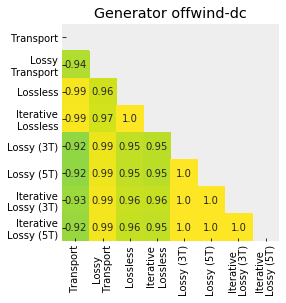

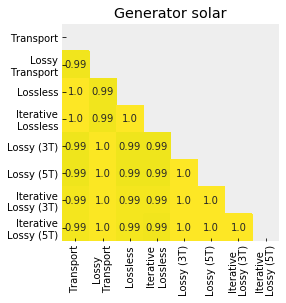

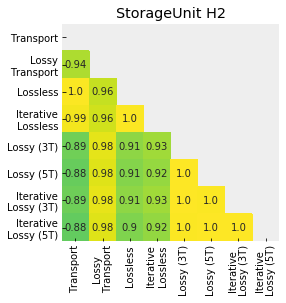

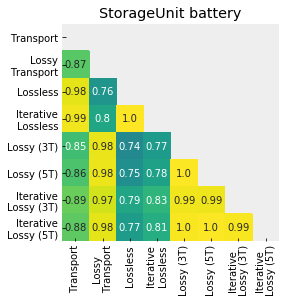

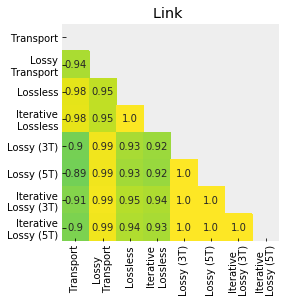

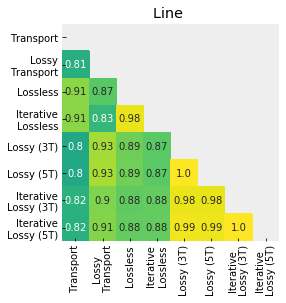

In [187]:
groups = {
    "Generator": ["onwind", "offwind-ac", "offwind-dc", "solar"],
    "StorageUnit": ["H2", "battery"],
    "Link": [""],
    "Line": [""]
}

for c, carriers in groups.items():
    for carrier in carriers:
        plot_capacity_correlation(networks, c, carrier, fn=f"{d}capacity-correlation-{c}-{carrier}.pdf")

In [188]:
pd.DataFrame({k: check_flow_errors(networks[k], networks_pf[k]) for k in networks.keys()}, index=["mse", "rmse", "mae", "mape", "corr", "r2"]).to_csv(f"{d}flow_errors.csv", **csvargs)

IndexError: list index out of range

In [ ]:
pd.DataFrame({k: check_capacities(v) for k, v in networks.items()}).to_csv(f"{d}capacity.csv", **csvargs)

In [189]:
pd.DataFrame({k: check_energy_generated(v) for k, v in networks.items()}).to_csv(f"{d}energy.csv", **csvargs)

In [190]:
pd.DataFrame({k: check_slack(v, pflogs[k]) for k, v in networks_pf.items()}).to_csv(f"{d}slack.csv", **csvargs)

In [191]:
pd.DataFrame({k: [check_curtailment(v), check_energy_transmitted(v), *check_costs(v), *check_energy_balance(v)] for k, v in networks.items()}, index=["curtailment", "energy-transmitted", "absolute-tsc", "relative-tsc", "energy-balance", "loss-share", "link-losses", "line-losses"]).to_csv(f"{d}misc.csv", **csvargs)

In [192]:
conv_share = pd.concat([convergence_share(pflogs[fm], fm) for fm in flow_models], axis=1)

In [193]:
conv_share.to_csv(f"{d}power-flow-convergence.csv")

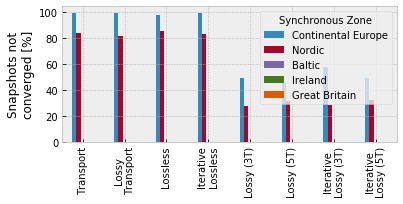

In [194]:
plot_nonconverged(conv_share, fn=f"{d}power-flow-convergence.pdf")

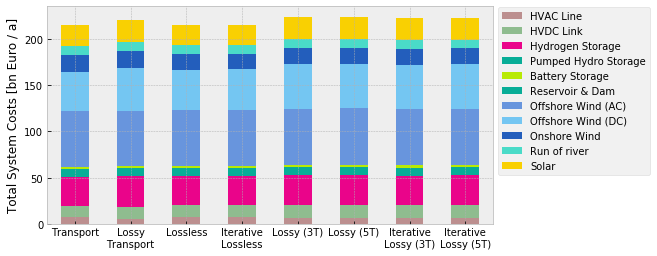

In [195]:
plot_cost_bar(networks, model_names, fn=f"{d}cost-bar.pdf")

s_nom             569.17
s_max_pu             0.7
r_pu_eff     0.000220682
s_nom_max        5569.17
Name: 3, dtype: object


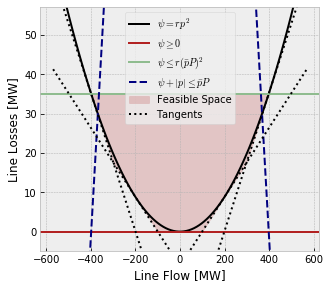

In [196]:
plot_feasible_space(networks["transport"].lines.iloc[2], fn=f"{d}feasiblespace.pdf")

transport
lossless-0
lossless-3
lossy-3-0


/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are

lossy-5-0


/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically ex

lossy-3-3


/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are

lossy-5-3


/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/ws/sp2668/software/anaconda3/envs/pypsa-eur-wave/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are

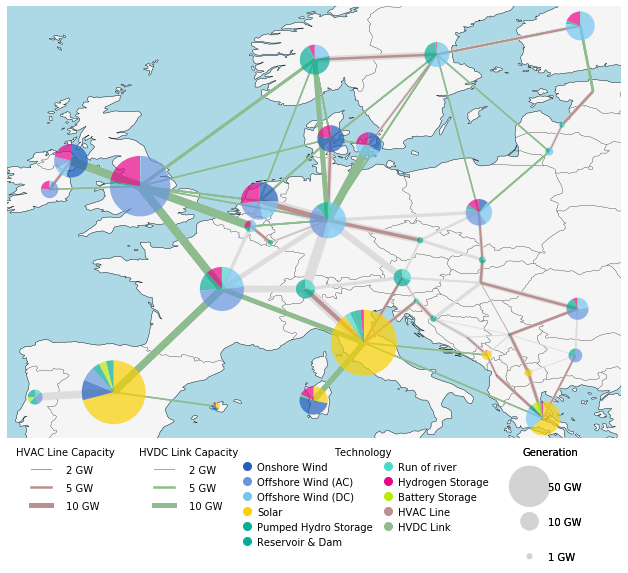

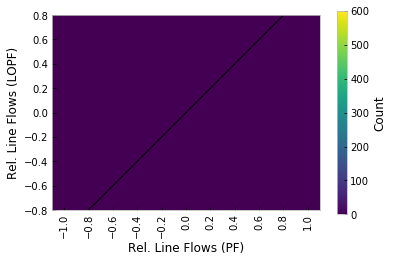

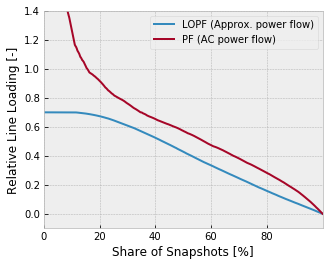

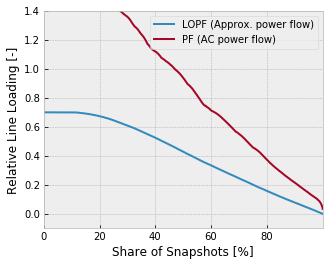

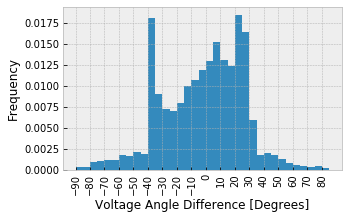

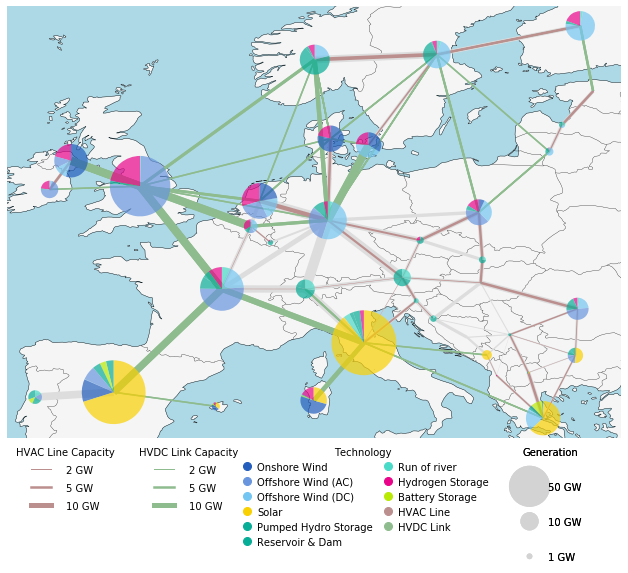

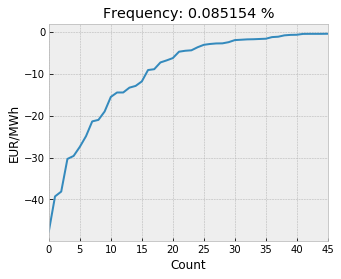

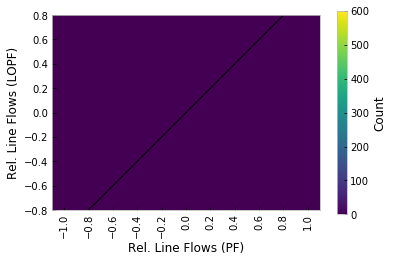

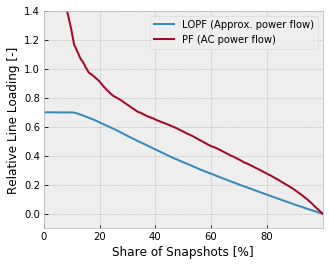

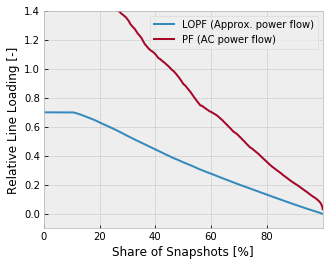

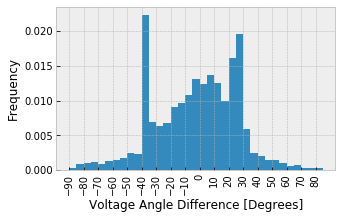

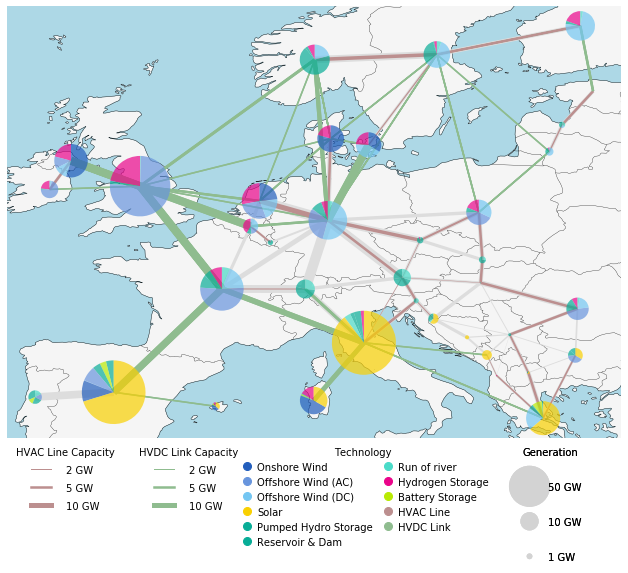

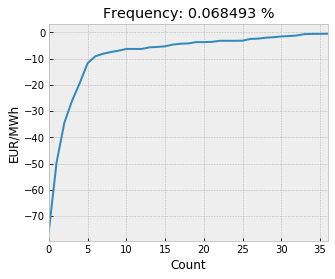

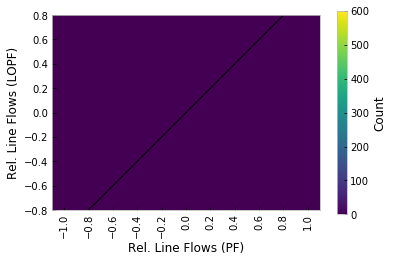

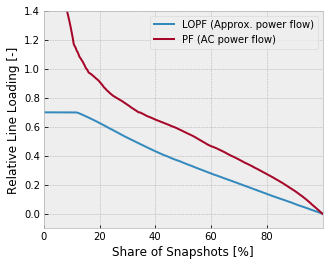

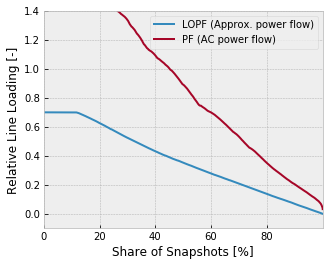

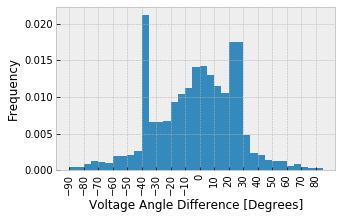

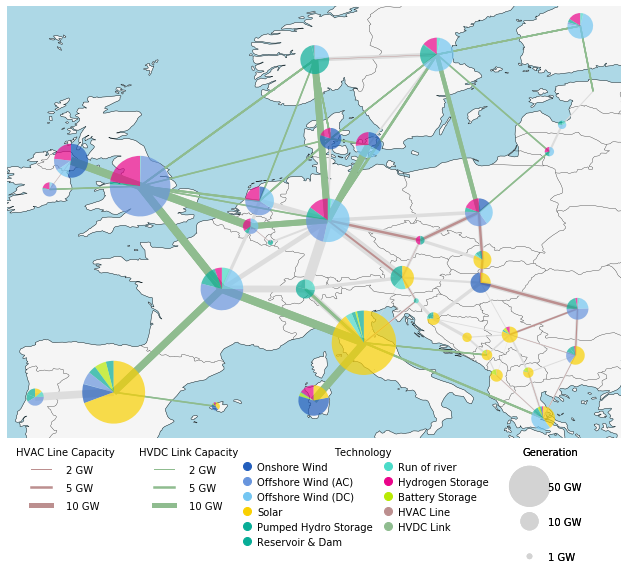

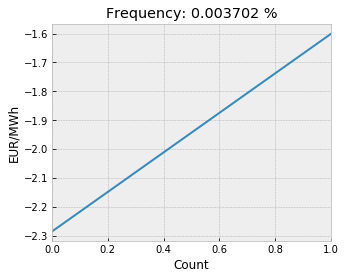

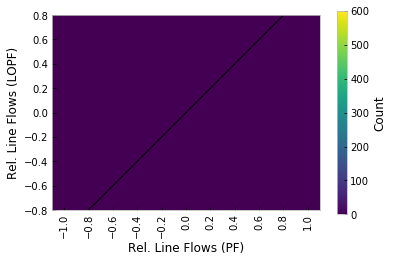

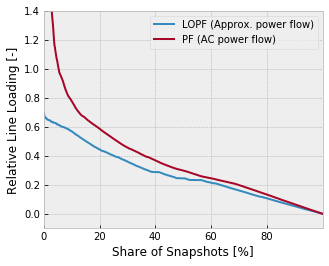

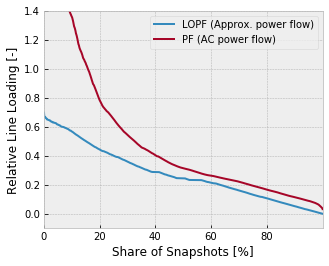

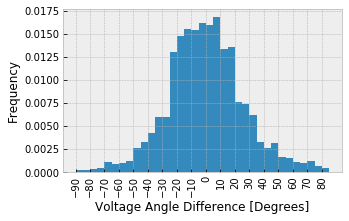

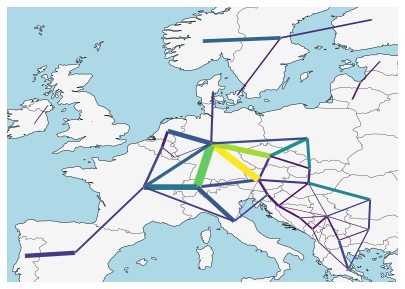

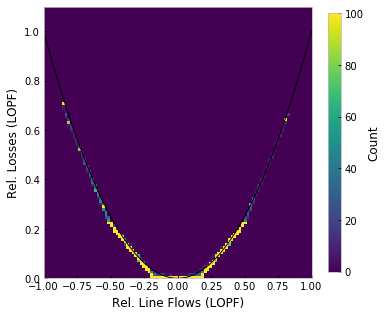

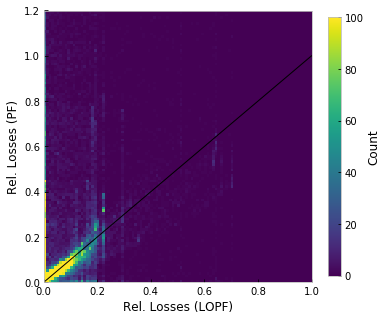

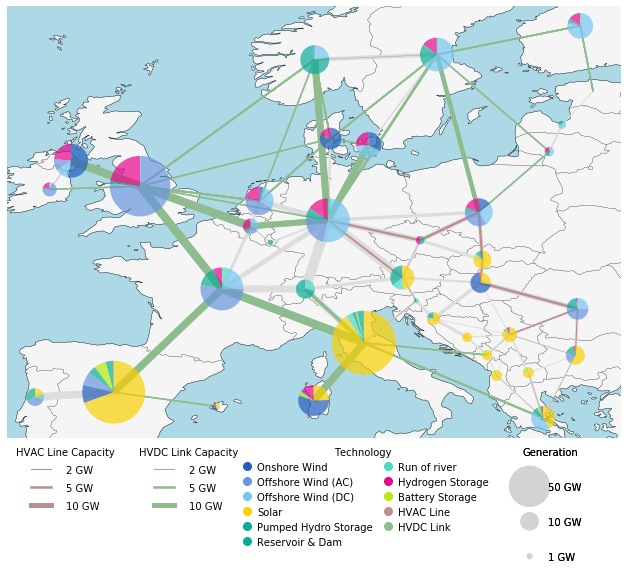

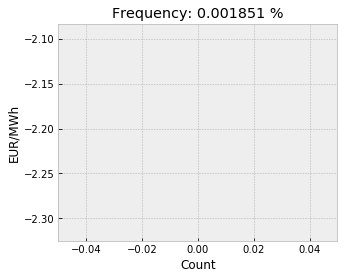

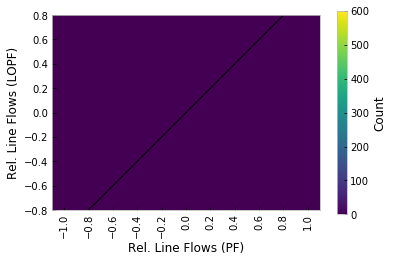

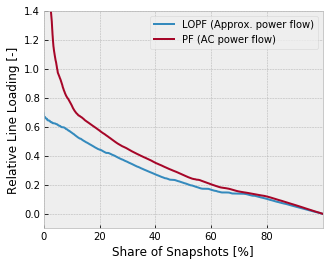

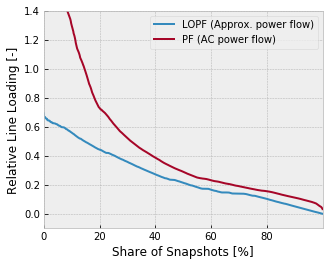

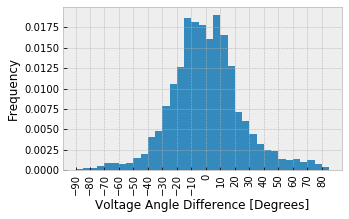

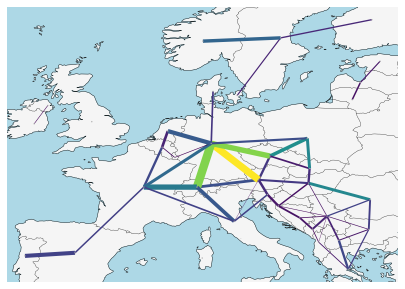

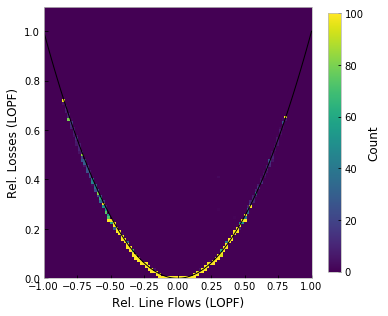

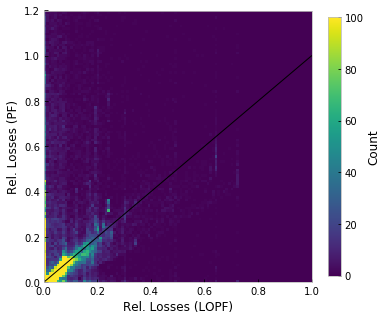

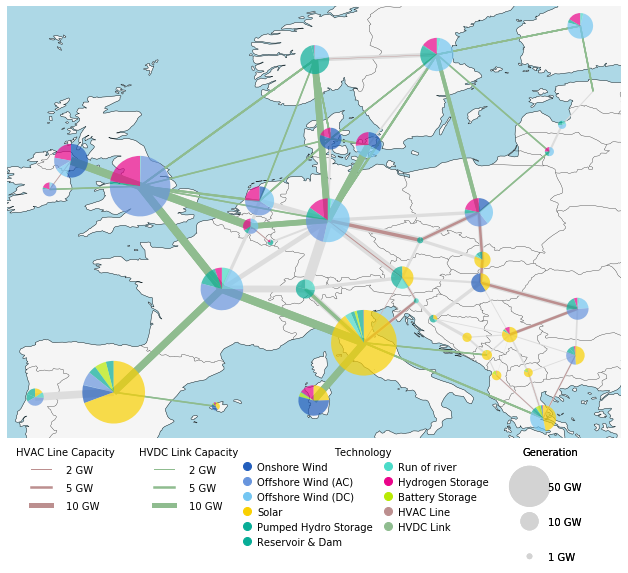

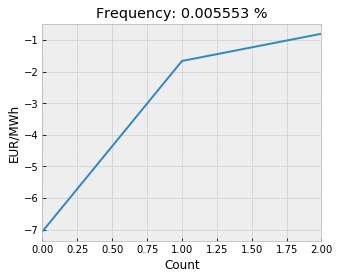

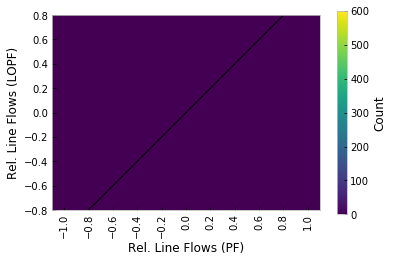

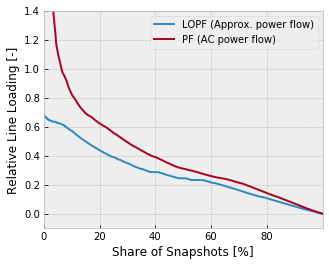

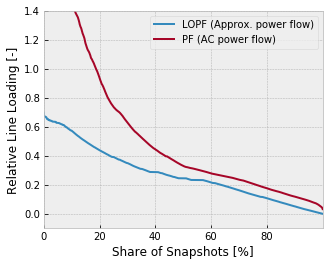

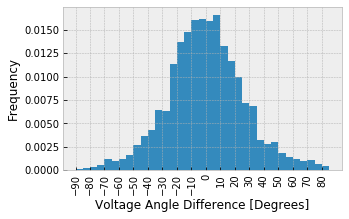

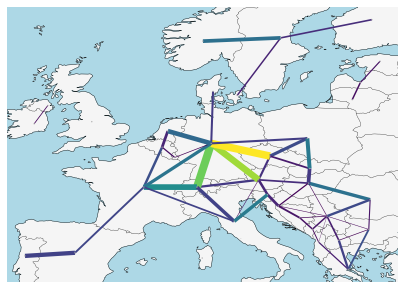

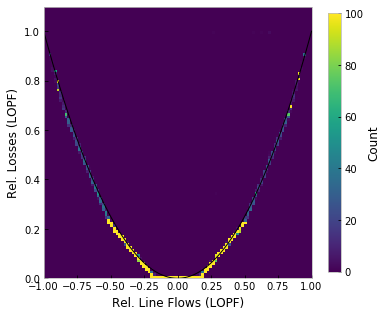

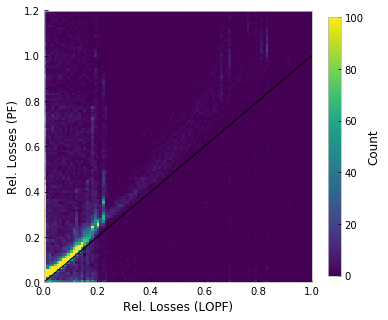

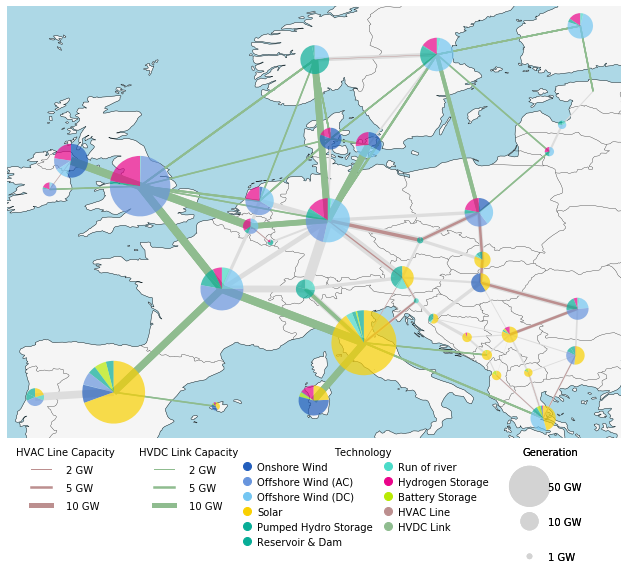

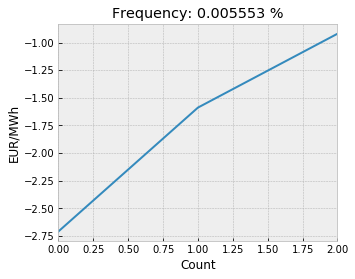

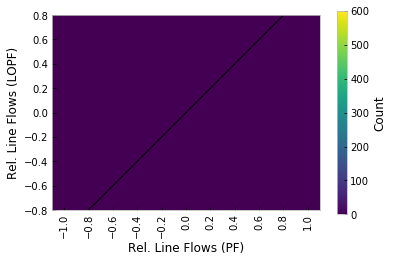

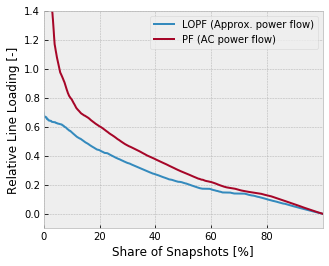

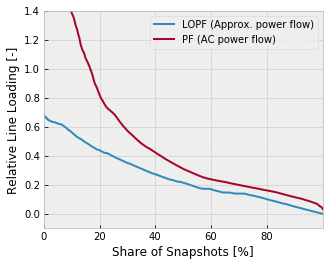

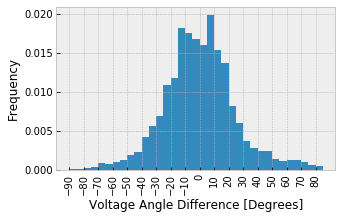

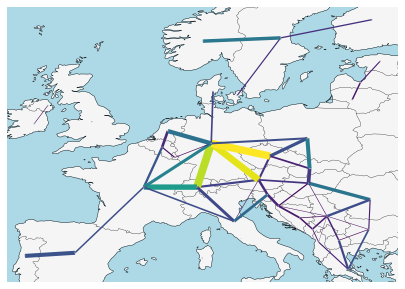

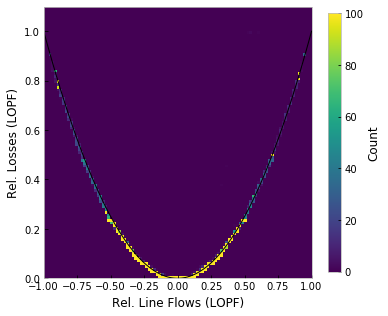

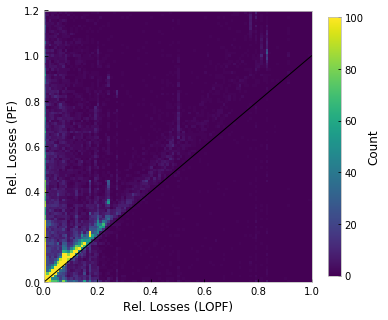

In [197]:
for name in networks.keys():
    
    if name=="lossytransport":
        continue
    
    print(name)
    
    n = networks[name]
    n_pf = networks_pf[name]
    
    plot_network(n, fn=f"{d}network-{name}.pdf")
    plot_negative_marginal_prices(n, fn=f"{d}negative-lmp-{name}.pdf")
    
    plot_flow_comparison(n, n_pf, fn=f"{d}flow-comparison-{name}.pdf")
    
    plot_duration_curve(n, n_pf, apparent=False, fn=f"{d}flow-duration-curve-p-{name}.pdf")
    plot_duration_curve(n, n_pf, apparent=True, fn=f"{d}flow-duration-curve-s-{name}.pdf")
    
    plot_v_ang_diff(n_pf, fn=f"{d}v-ang-diff-{name}.pdf")
    
    if "lossy" in name:
        plot_network_losses(n, fn = f"{d}network-losses-{name}.pdf")
        plot_flow_vs_loss(n, fn=f"{d}flow-vs-loss-{name}.pdf")
        plot_loss_comparison(n, n_pf, fn=f"{d}loss-comparison-{name}.pdf")